# Ensembles classifiers using trees on the Iris Dataset

In this notebook we apply several ensemble methods to the Iris dataset using tree classifiers and plot the resulting decision surfaces. Note that this notebook has been created using the material from http://scikit-learn.org/stable/modules/ensemble.html

First we load all the required libraries.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Constructs a new estimator with the same parameters.
# Clone does a deep copy of the model in an estimator 
# without actually copying attached data. It yields a 
# new estimator with the same parameters that has not 
# been fit on any data.
from sklearn import clone 

from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,BaggingClassifier)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Next we define some of the parameters required to run the experiments like the number of estimators used in each ensembles and the random seed to be able to reproduce the results.

In [15]:
# Number of estimators used in each ensemble
n_estimators = 30

# Set the random seed to be able to repeat the experiment
random_seed = 42 

Load the dataset

In [16]:
iris = load_iris()

Set the models to be compared
- Simple Decision Tree
- Bagging
- Random Forest
- AdaBoost

In [31]:
models = {'Decision Tree':DecisionTreeClassifier(),
          'Bagging':BaggingClassifier(DecisionTreeClassifier(),n_estimators=n_estimators),
          'Random Forest':RandomForestClassifier(n_estimators=n_estimators),
          'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=n_estimators)}

For each model, we apply 10-fold stratified crossvalidation and compute the average accuracy and the corresponding standard deviation

In [32]:
scores = {}
for pair in ([0, 1], [0, 2], [2, 3]):
    for model_name in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        clf = models[model_name];
        score = cross_val_score(clf,X,y,cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=random_seed))
        scores[(model_name,str(pair))]=(np.average(score),np.std(score))

Then, we print for every variable pair the performance of all the models

In [33]:
for pair in ([0, 1], [0, 2], [2, 3]):
    print 'Attributes: ',iris.feature_names[pair[0]],' & ',iris.feature_names[pair[1]]
    for model_name in models:
        print '\t%26s\t%.3f +/- %.3f'%(model_name,scores[(model_name,str(pair))][0],scores[(model_name,str(pair))][1])
    print('\n')

Attributes:  sepal length (cm)  &  sepal width (cm)
	                   Bagging	0.700 +/- 0.075
	                 Ada Boost	0.700 +/- 0.100
	             Random Forest	0.720 +/- 0.078
	             Decision Tree	0.640 +/- 0.080


Attributes:  sepal length (cm)  &  petal length (cm)
	                   Bagging	0.940 +/- 0.036
	                 Ada Boost	0.920 +/- 0.050
	             Random Forest	0.927 +/- 0.036
	             Decision Tree	0.920 +/- 0.040


Attributes:  petal length (cm)  &  petal width (cm)
	                   Bagging	0.960 +/- 0.044
	                 Ada Boost	0.953 +/- 0.031
	             Random Forest	0.967 +/- 0.045
	             Decision Tree	0.947 +/- 0.040




Finally, we plot the decision surfaces for every model and every attribute combination.
- Decision tree classifier (first column)
- Bagging (second column)
- Random forest (third column)
- AdaBoost (fourth column)


Attributes:  sepal length (cm)  &  sepal width (cm)
	                   Bagging	0.927
	                 Ada Boost	0.927
	             Random Forest	0.920
	             Decision Tree	0.927

Attributes:  sepal length (cm)  &  petal length (cm)
	                   Bagging	0.993
	                 Ada Boost	0.993
	             Random Forest	0.993
	             Decision Tree	0.993

Attributes:  petal length (cm)  &  petal width (cm)
	                   Bagging	0.993
	                 Ada Boost	0.993
	             Random Forest	0.993
	             Decision Tree	0.993


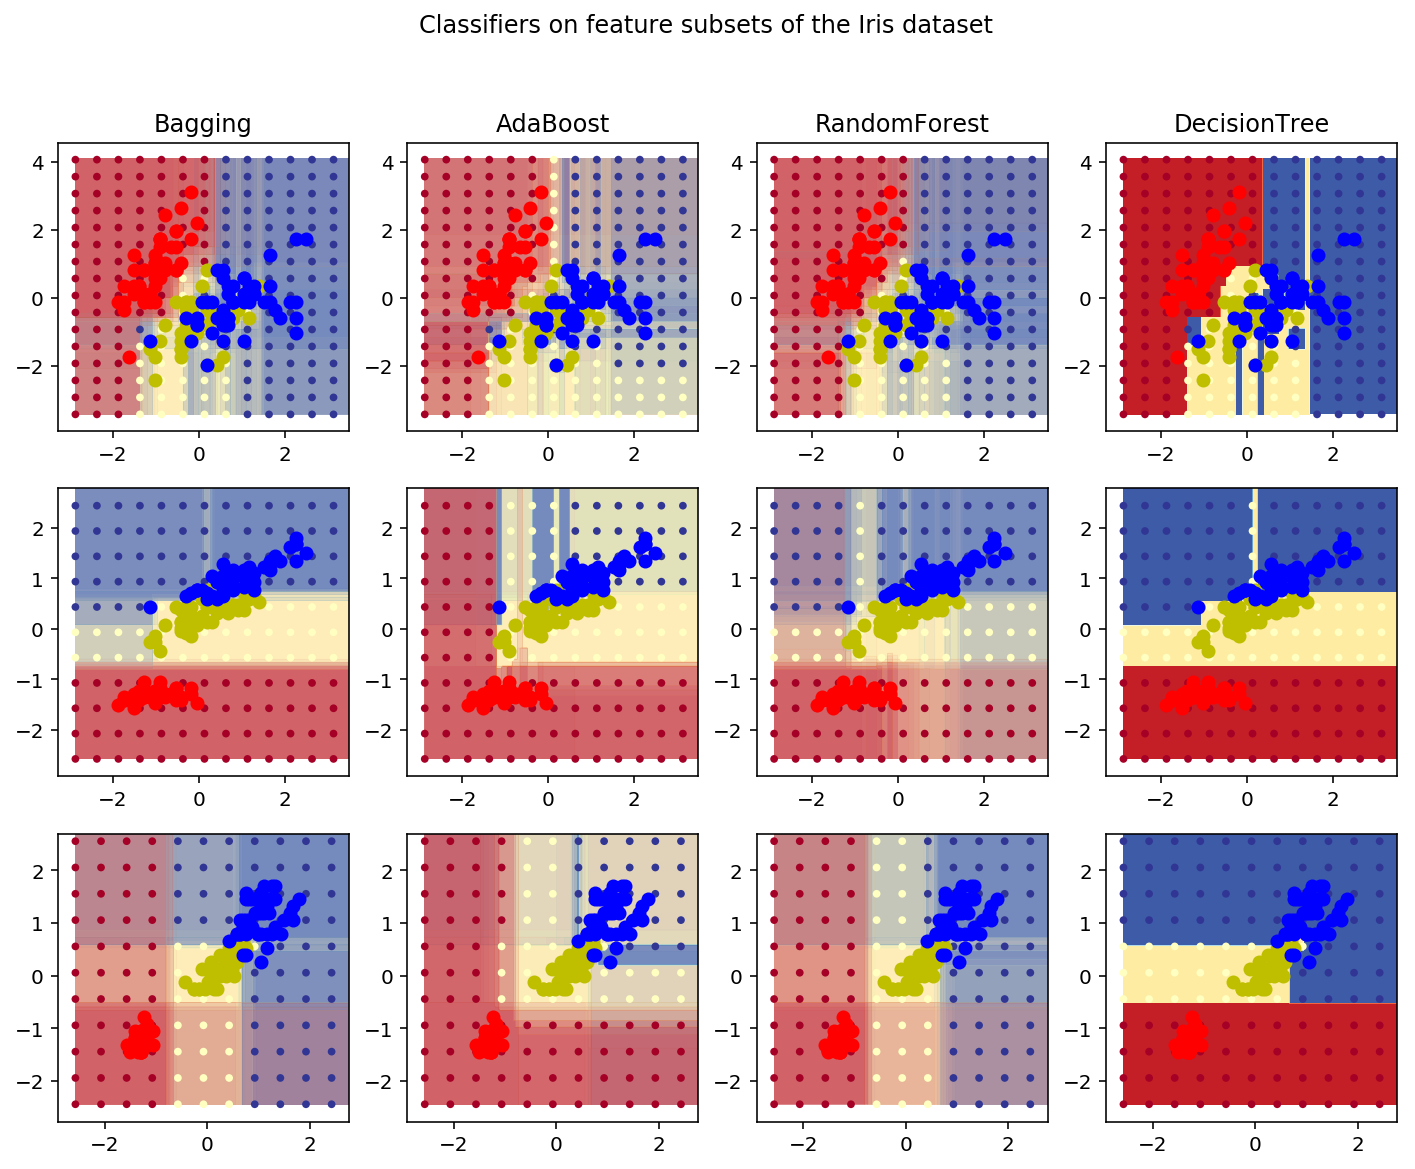

In [36]:
n_classes = 3
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

plot_idx = 1

plt.figure(figsize=(12,9))
for pair in ([0, 1], [0, 2], [2, 3]):
    print '\nAttributes: ',iris.feature_names[pair[0]],' & ',iris.feature_names[pair[1]]


    for model_name in models:
        model = models[model_name]
        
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(random_seed)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title

        print '\t%26s\t%.3f'%(model_name,scores)



        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
                        
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()